In [15]:
import numpy as np
from adaptive_latents.regressions import VanillaOnlineRegressor
import matplotlib.pyplot as plt

from tqdm import tqdm

from adaptive_latents.input_sources import jpca
from adaptive_latents.bw_run import AnimationManager
import adaptive_latents

from scipy.io import loadmat

rng = np.random.default_rng()

## Load Data

In [12]:
obs, raw_behavior, bin_centers, beh_t = adaptive_latents.input_sources.datasets.construct_buzaki_data(individual_identifier=adaptive_latents.input_sources.datasets.individual_identifiers["buzaki"][0], bin_width=0.015)
obs = adaptive_latents.input_sources.prosvd_data(input_arr=obs, output_d=6, init_size=50)
obs = adaptive_latents.input_sources.functional.center_from_first_n(obs)

retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/buzaki_data_419935096787334.pickle
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/prosvd_data_663752537319686.pickle


In [13]:
obs, raw_behavior, bin_centers, beh_t = adaptive_latents.input_sources.datasets.construct_indy_data(
    adaptive_latents.input_sources.datasets.individual_identifiers["indy"][0],
    bin_width=0.06,
)
obs = adaptive_latents.input_sources.prosvd_data(input_arr=obs, output_d=6, init_size=50)
obs = adaptive_latents.input_sources.functional.center_from_first_n(obs)

retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/prosvd_data_989957084343038.pickle


In [22]:
data = loadmat(adaptive_latents.CONFIG["data_path"] / 'church' / 'exampleData.mat', squeeze_me=True, simplify_cells=True)['Data']
A = []
times = data[0]['times']
for d in data:
    A.append(d['A'])
    assert np.all(times == d['times'])
A = np.array(A)


AA = np.array(A)
AA[:,-1,:] = np.nan
obs = AA.reshape((-1, 218))

# obs -= np.nanmean(obs,axis=0)
obs = adaptive_latents.input_sources.prosvd_data(input_arr=obs, output_d=6, init_size=50)

retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/prosvd_data_152128882084536.pickle


## Make a Movie

In [20]:
m, n = 2000, 4
X, _, true_variables = jpca.generate_circle_embedded_in_high_d(rng,m=2000,n=4)

In [27]:
X = obs
true_variables = None

In [28]:
class CustomAnimation(AnimationManager):
    n_rows = 1
    n_cols = 1
    fps = 40
    def draw_frame(self, step, history):
        self.ax[0,0].cla()
        self.ax[0,0].plot(history[-100:,0], history[-100:,1])
        self.ax[0,0].set_title(f"step {step}")
        self.movie_writer.grab_frame()


100%|████████████████████████████████████████████████████████████████████████| 6536/6536 [00:39<00:00, 165.22it/s]


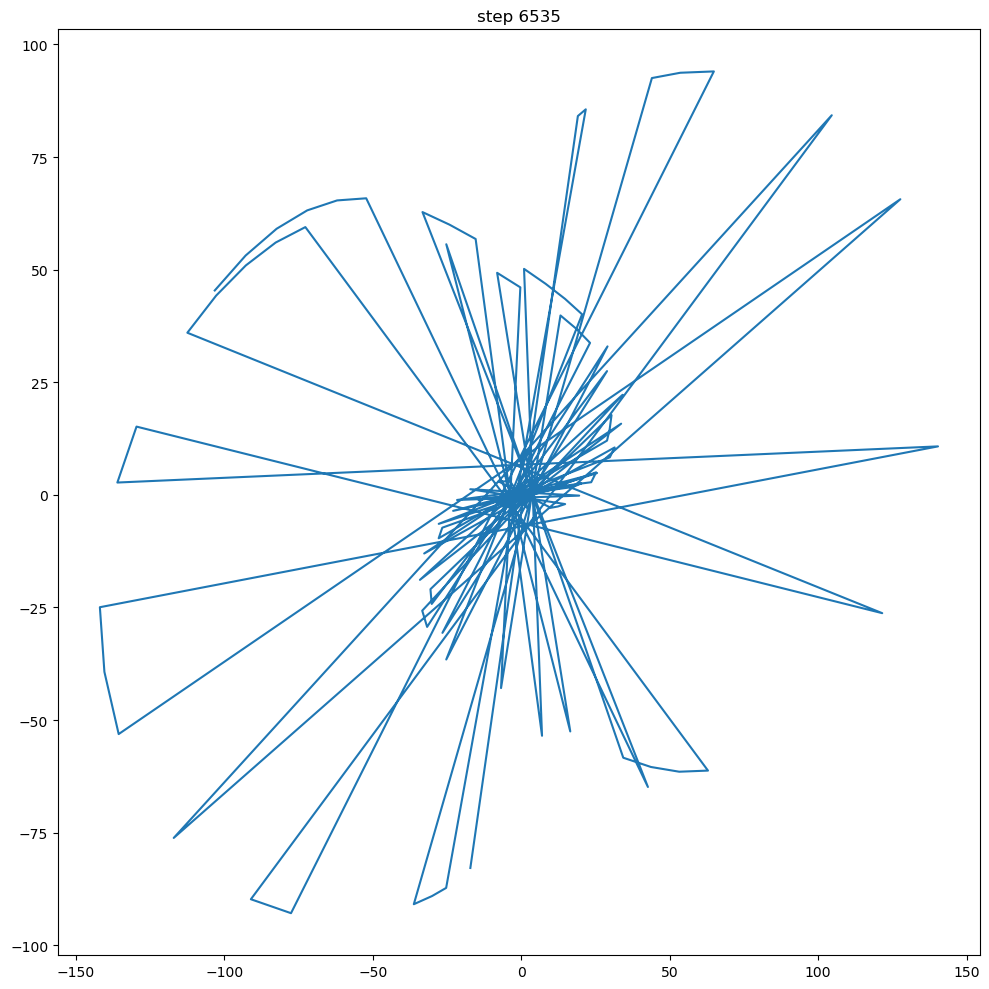

In [31]:
X, X_dot = jpca.X_and_X_dot_from_data(X)
m, n = X.shape

H = jpca.make_H(n)
reg = VanillaOnlineRegressor(input_d=H.shape[1], output_d=1, init_min_ratio=2)

am = CustomAnimation()
observations = []
errors = []
for i in tqdm(range(X.shape[0])):
    rows = jpca.make_X_tilde(X[i, None]) @ H
    for j in range(n):
        x = rows[j]
        y = X_dot[i, j]
        reg.safe_observe(x, y)
    U = jpca.U_from_beta(reg.get_beta(), n)
    observations.append(X[i] @ U)
    if i > 6000:
        am.draw_frame(i,np.array(observations))
    if true_variables is not None:
        try:
            A,B = jpca.align_column_spaces(U[:,:2], true_variables['C'])
            errors.append(np.linalg.norm(A-B))
        except np.linalg.LinAlgError:
            errors.append(np.nan)

observations = np.array(observations)

In [33]:
am.set_final_output_location("/home/jgould/Documents/AdaptiveLatents/scripts/generated/other/animation.mp4")
am.finish()

FileNotFoundError: [Errno 2] No such file or directory: './movie.mp4' -> '/home/jgould/Documents/AdaptiveLatents/scripts/generated/other/animation.mp4'

In [35]:
mv ./movie.mp4 ../generated/other/animation.mp4